<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/CNN3D_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Importation des données et librairies**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow
import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import TimeDistributed
from keras.layers import Conv3D, BatchNormalization,MaxPooling3D, GlobalMaxPool3D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix




In [3]:
hf_normal= h5py.File("/content/drive/MyDrive/UV PROJET P6/Dataset_normal.hdf5", "r")
hf_malade= h5py.File("/content/drive/MyDrive/UV PROJET P6/Dataset_malade.hdf5", "r")

Data_normal = np.array(hf_normal["dataset_1"][:]) #dataset_name is same as hdf5 object name 
Data_malade = np.array(hf_malade["dataset_2"][:])

# **1 - Etude des données et création des labels**



In [4]:
Data_normal.shape , Data_malade.shape

((55720, 48, 48), (54600, 48, 48))

In [5]:
Data_normal = Data_normal.reshape(Data_normal.shape[0]//70,70,48,48) # work on 1576 samples of 70 scans of size 48*48
Data_malade = Data_malade.reshape(Data_malade.shape[0]//70,70,48,48) # work on 1576 samples of 70 scans of size 48*48
Data = np.concatenate((Data_normal,Data_malade))
Data.shape

(1576, 70, 48, 48)

Le jeu de données est composé de séquences de 70 images par scan, c'est pourquoi on atteibue un label pour chaque séquence :
- 0 : La personne est négative au COVID. 
- 1 : La personne est positive au COVID

In [6]:
Y_normal = np.zeros(Data_normal.shape[0],dtype = np.int8) # 70 images per scan
Y_malade = np.ones(Data_malade.shape[0],dtype = np.int8)
Y = np.concatenate((Y_normal,Y_malade))
Y.shape


(1576,)

# **2 - Création d'un modèle CNN3D + GRU**




In [7]:
def build_convnet(shape=(70,48, 48)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv3D(64, (3,3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling3D())
    
    model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
    model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalMaxPool3D())
    return model

In [8]:
def action_model(shape=(70,48, 48,1), nbout=1):
    convnet = build_convnet(shape)
    
    model = keras.Sequential()
    model.add(convnet)
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

In [9]:
# some global params
SIZE = (48, 48)
NBFRAME = 70
BS = 8
CHANNEL = 1

In [10]:
INSHAPE=(70,48,48,1)
model = action_model(INSHAPE, nbout=1)
optimizer = tensorflow.keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

On fixe la graine aléatoire afin que l'on puisse avoir des résultats similaires en relançant l'apprentissage : 

In [11]:
def fix_seed(seed):
    tensorflow.random.set_seed(seed)

SEED = 42
fix_seed(SEED)

On utilise les callbacks EarlyStop et ModelCheckpoint pour optimiser nos résultats : 

In [12]:
my_callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='/tmp/myModel.h5')
]



# **3 - Apprentissage et interprétation des résultats**


In [13]:
model.fit(Data,Y,epochs=50, validation_split=0.2, batch_size=BS, callbacks=my_callbacks)

Epoch 1/50
158/158 [==============================] - 104s 552ms/step - loss: 0.9900 - acc: 0.5365 - val_loss: 1.1575 - val_acc: 0.0095
Epoch 2/50
158/158 [==============================] - 88s 556ms/step - loss: 0.7015 - acc: 0.5857 - val_loss: 0.7884 - val_acc: 0.0095
Epoch 3/50
158/158 [==============================] - 89s 566ms/step - loss: 0.6818 - acc: 0.6198 - val_loss: 0.8968 - val_acc: 0.0095
Epoch 4/50
158/158 [==============================] - 90s 567ms/step - loss: 0.6569 - acc: 0.6310 - val_loss: 1.1736 - val_acc: 0.0095
Epoch 5/50
158/158 [==============================] - 89s 567ms/step - loss: 0.6896 - acc: 0.6198 - val_loss: 0.7153 - val_acc: 0.0000e+00
Epoch 6/50
158/158 [==============================] - 90s 567ms/step - loss: 0.6811 - acc: 0.6024 - val_loss: 0.8436 - val_acc: 0.0000e+00
Epoch 7/50
158/158 [==============================] - 89s 564ms/step - loss: 0.6315 - acc: 0.6556 - val_loss: 0.4586 - val_acc: 0.7437
Epoch 8/50
158/158 [==========================

On récupère le meilleur modèle, c'est à dire celui de l'epoch 29 

In [24]:
model.load_weights("/tmp/myModel.h5")



[0.5365079641342163, 0.5857142806053162, 0.6198412775993347, 0.6309523582458496, 0.6198412775993347, 0.6023809313774109, 0.6555555462837219, 0.7666666507720947, 0.8666666746139526, 0.8682539463043213, 0.867460310459137, 0.882539689540863, 0.8920634984970093, 0.8976190686225891, 0.8920634984970093, 0.9039682745933533, 0.908730149269104, 0.9182539582252502, 0.9095237851142883, 0.9111111164093018, 0.9190475940704346, 0.9261904954910278, 0.9277777671813965, 0.9420635104179382, 0.9293650984764099, 0.9341269731521606, 0.9373015761375427, 0.946825385093689, 0.9547619223594666, 0.9507936239242554, 0.9515873193740845, 0.9515873193740845, 0.9626984000205994, 0.9571428298950195, 0.961904764175415, 0.9579365253448486, 0.9642857313156128, 0.9666666388511658, 0.9531745910644531, 0.9603174328804016, 0.9730158448219299, 0.973809540271759, 0.9690476059913635, 0.961904764175415, 0.958730161190033, 0.9722222089767456, 0.9658730030059814, 0.970634937286377, 0.9714285731315613, 0.9857142567634583]
[0.00949

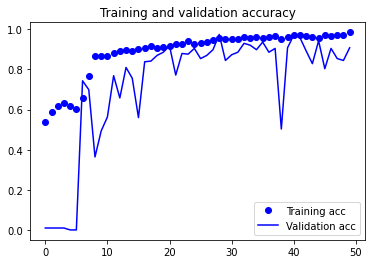

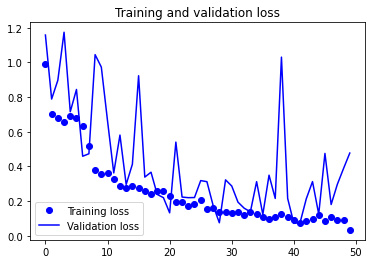

In [16]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)

print(loss)
print(val_loss)

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **4 - Test sur un jeu de données aléatoire**


In [25]:
Data_test = []
for i in range(25):
  aleatoire = np.random.randint(0,Data_normal.shape[0])
  Data_test.append(Data_normal[aleatoire][:])
for i in range(25):
  aleatoire = np.random.randint(0,Data_malade.shape[0])
  Data_test.append(Data_malade[aleatoire][:])
Data_test = np.array(Data_test)
Data_test.shape

(50, 70, 48, 48)

In [27]:
Y_test_normal= np.zeros(25)
Y_test_malade = np.ones(25)
Y_test = np.concatenate((Y_test_normal,Y_test_malade))

In [28]:
model.evaluate(Data_test,Y_test)

2/2 [==============================] - 6s 2s/step - loss: 0.3699 - acc: 0.9400


[0.3698709011077881, 0.9399999976158142]

In [29]:
preds = np.round(model.predict(Data_test),0)
cm = confusion_matrix(Y_test, preds)
print(cm)


[[25  0]
 [ 3 22]]


Le modèle est plus efficace que les modèles 2D, il prédit avec une accuracy de 93% sur un jeu de donnée aléatoire en test.